# $\Delta E$ vs. $E$ detector simulation a lá SiRi

A type of detector which is sometimes used in e.g. Nuclear Physics, is a $\Delta E$ vs. $E$ detector.
This is a two-layer semiconductor detector, where the first layer slows down the particle, while the second layer works like a calorimeter and stops it.
This is used with low energy (few MeV) protons.

One such detector is described in M. Guttormsen et al., "The SiRi particle-telescope system", NIM-A 2011: https://www.sciencedirect.com/science/article/pii/S0168900211010205
In this demonstration, we will reproduce something like Figure 4 of this paper through simulation.



## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import stats
import ROOT
import os

Welcome to JupyROOT 6.24/06


In [2]:
%matplotlib notebook

# plt.rcParams['figure.figsize'] = [8, 5]
# plt.rcParams['figure.dpi'] = 100
# 
# #colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [3]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [4]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)
#import CLEARview

import miniScatterDriver
import miniScatterScanner
import miniScatterPlots

## Physics setup

In [5]:
### Basic simulation parameters ###

QUIET = False
TRYLOAD = True #Try to load already existing data instead of recomputing?

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS"
#baseSimSetup["PHYS"] = "QGSP_BERT"
baseSimSetup["PHYS"] = "QGSP_BERT_EMV"
baseSimSetup["N"] = 100000

#Disable the default target
baseSimSetup["THICK"] = 0.0

#Start beam 10 mm before center of coordinate system
baseSimSetup["ZOFFSET"] = -10

#Make three layers of not-actually-a-magnet
baseSimSetup["MAGNET"] = []
#All thicknesses in [mm]
thickness_de = 0.130
thickness_e  = 1.550
thickness_foil = 10e-3
thickness_buffer = 5e-3 #Some distance-keeping to avoid overlaps
#DeltaE-detector
m1 = {}
m1["pos"]      = 0.0
m1["type"]     = "TARGET"
m1["length"]   = thickness_de #[mm]
m1["gradient"] = 0.0
m1["keyval"] = {}
m1["keyval"]["material"] = "G4_Si"
m1["keyval"]["width"]    = 15.0 #[mm]
m1["keyval"]["height"]   = 15.0 #[mm]
baseSimSetup["MAGNET"].append(m1)
#E-detector
m2 = {}
m2["pos"]      = thickness_de/2 + thickness_e/2 + thickness_foil + 2*thickness_buffer
m2["type"]     = "TARGET"
m2["length"]   = thickness_e #[mm]
m2["gradient"] = 0.0
m2["keyval"]   = {}
m2["keyval"]["material"] = "G4_Si"
m2["keyval"]["width"]    = 15.0 #[mm]
m2["keyval"]["height"]   = 15.0 #[mm]
baseSimSetup["MAGNET"].append(m2)
#Al foil to reduce delta electrons.
# Define this last so that it can be removed without changing numberings
m3 = {}
m3["pos"]      = thickness_de/2 + thickness_foil/2 + thickness_buffer
m3["type"]     = "TARGET"
m3["length"]   = thickness_foil #[mm]
m3["gradient"] = 0.0
m3["keyval"] = {}
m3["keyval"]["material"] = "G4_Al"
m3["keyval"]["width"]    = 15.0 #[mm]
m3["keyval"]["height"]   = 15.0 #[mm]
baseSimSetup["MAGNET"].append(m3)


baseSimSetup["WORLDSIZE"] = 20.0 #[mm], x-y size of the world

baseSimSetup["DIST"] = 5.0 #Perfect-detector position [mm] 

baseSimSetup["QUICKMODE"] = False #Include slow plots
baseSimSetup["MINIROOT"]  = True #Skip TTRees in the .root files

#Lowest energy particles to consider for analysis
#E_CUTOFF = baseSimSetup["ENERGY"]*0.9;

#Store the .root files in a subfolder from MiniScatter/examples, to be easy to find
baseSimSetup["OUTFOLDER"]=os.path.join(os.getcwd(),"DeltaEE")


In [6]:
# Test simulation
baseSimSetup_test = baseSimSetup.copy()
baseSimSetup_test["BEAM"]    = "proton"
baseSimSetup_test["ENERGY"]  = 10.0 #[MeV]
baseSimSetup_test["OUTNAME"] = "test"

(twiss_test, numPart_test, objects_test) = miniScatterDriver.getData_tryLoad(baseSimSetup_test, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_2_edep","magnet_3_edep","metadata"])

Did not find any pre-computed data at '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test.root', computing now.
Running command line: './MiniScatter --thick 0.0 --dist 5.0 --worldsize 20.0 --phys QGSP_BERT_EMV --numEvents 100000 --energy 10.0 --beam proton --zoffset -10 --outname test --outfolder /mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE --miniroot --magnet 0.0:TARGET:0.13:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.8600000000000001:TARGET:1.55:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.07500000000000001:TARGET:0.01:0.0:material=G4_Al:width=15.0:height=15.0'
RunFolder = '/mn/kvant/u5/kyrrens/code/MiniScatter/build'
logName   = '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test.txt'
\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
Event# 10000
Event# 

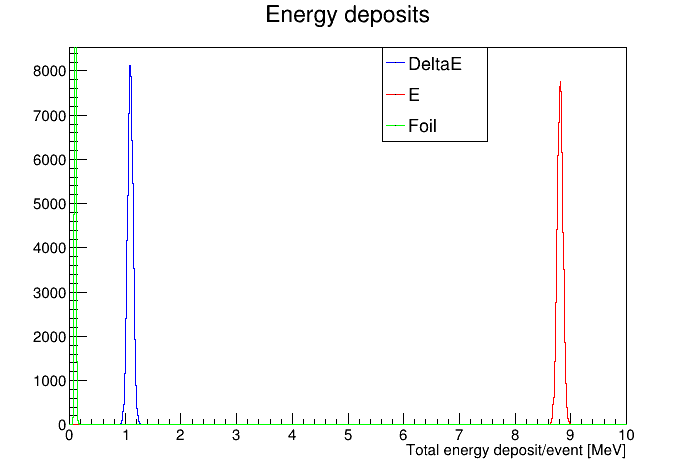

In [7]:
c1 = ROOT.TCanvas()

#DeltaE detector
objects_test["magnet_1_edep"].SetTitle("Energy deposits")
objects_test["magnet_1_edep"].SetStats(False)
objects_test["magnet_1_edep"].SetLineColor(ROOT.kBlue)
objects_test["magnet_1_edep"].Draw()

#E detector
objects_test["magnet_2_edep"].SetLineColor(ROOT.kRed)
objects_test["magnet_2_edep"].Draw("same")

#Foil
objects_test["magnet_3_edep"].SetLineColor(ROOT.kGreen)
objects_test["magnet_3_edep"].Draw("same")

l = ROOT.TLegend(0.55,0.7,0.7,0.9);
l.AddEntry(objects_test["magnet_1_edep"],"DeltaE")
l.AddEntry(objects_test["magnet_2_edep"],"E")
l.AddEntry(objects_test["magnet_3_edep"],"Foil")
l.Draw()

c1.Draw()

In [8]:
# Test simulation with energy distribution -- protons
baseSimSetup_test2 = baseSimSetup.copy()
baseSimSetup_test2["BEAM"]         = "proton"
baseSimSetup_test2["ENERGY"]       = 20.0       #Reference energy[MeV]
baseSimSetup_test2["ENERGY_FLAT"]  = [1.0,50.0] #Energy distribution[MeV]

baseSimSetup_test2["MINIROOT"]     = False #I want TTrees

baseSimSetup_test2["OUTNAME"]      = "test2"

(twiss_test2, numPart_test2, objects_test2, datafile_test2) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test2, getRaw=True, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_2_edep","magnet_3_edep","init_E","metadata"])

Did not find any pre-computed data at '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test2.root', computing now.
Running command line: './MiniScatter --thick 0.0 --dist 5.0 --worldsize 20.0 --phys QGSP_BERT_EMV --numEvents 100000 --energy 20.0 --energyDistFlat 1.0:50.0 --beam proton --zoffset -10 --outname test2 --outfolder /mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE --magnet 0.0:TARGET:0.13:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.8600000000000001:TARGET:1.55:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.07500000000000001:TARGET:0.01:0.0:material=G4_Al:width=15.0:height=15.0'
RunFolder = '/mn/kvant/u5/kyrrens/code/MiniScatter/build'
logName   = '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test2.txt'
\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
Ev

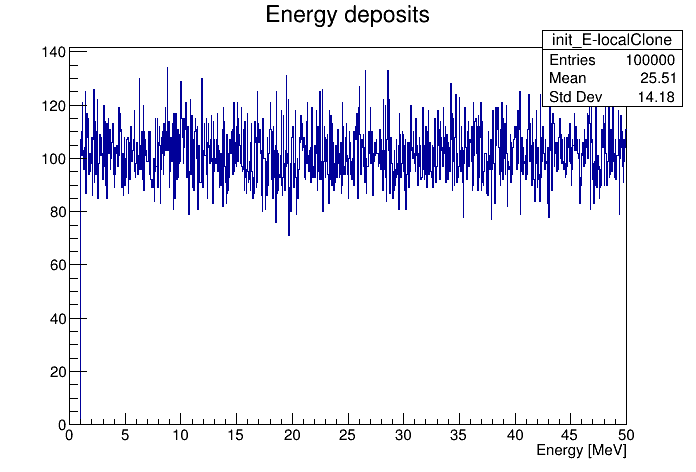

In [9]:
c1 = ROOT.TCanvas()

objects_test2["init_E"].SetTitle("Energy deposits")
#objects_test2["init_E"].SetStats(False)
objects_test2["init_E"].Draw()

c1.Draw()

In [10]:
th = datafile_test2.Get("magnetEdeps")
#th.Print()
#print(dir(th))

nbins_small = 500
nbins_big   = 1000

correlation_all = ROOT.TH2D("de-E_all", "Delta E vs E (all)", nbins_big, 0, 40, nbins_big, 0, 15)
correlation_pro = ROOT.TH2D("de-E_pro", "Delta E vs E (protons)", nbins_small, 0, 20, nbins_small, 0, 8)

for i in range(th.GetEntries()):
    th.GetEntry(i)
    #print(th.magnet_1)
    correlation_pro.Fill(th.magnet_2, th.magnet_1)
    correlation_all.Fill(th.magnet_2, th.magnet_1)

correlation_pro.SetXTitle("E [MeV]")    
correlation_pro.SetYTitle("Delta E [MeV]")


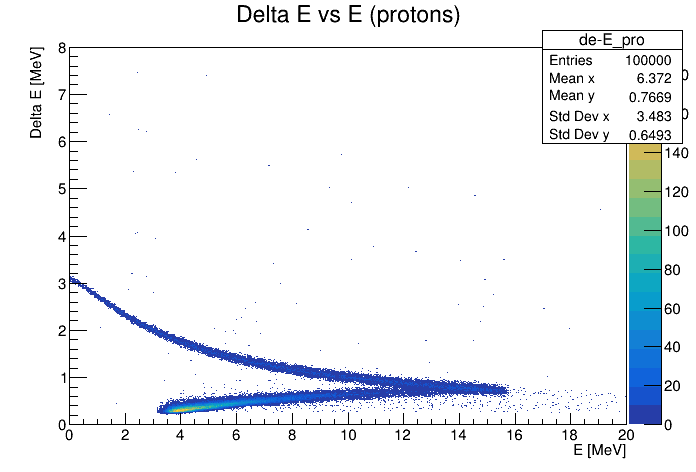

In [11]:
c1 = ROOT.TCanvas()
correlation_pro.Draw("colz")
c1.Draw()

In [12]:
#datafile_test2.Close() #Messes with ROOT storage of histograms...

Did not find any pre-computed data at '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test3.root', computing now.
Running command line: './MiniScatter --thick 0.0 --dist 5.0 --worldsize 20.0 --phys QGSP_BERT_EMV --numEvents 100000 --energy 20.0 --energyDistFlat 1.0:40.0 --beam ion::1;2 --zoffset -10 --outname test3 --outfolder /mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE --magnet 0.0:TARGET:0.13:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.8600000000000001:TARGET:1.55:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.07500000000000001:TARGET:0.01:0.0:material=G4_Al:width=15.0:height=15.0'
RunFolder = '/mn/kvant/u5/kyrrens/code/MiniScatter/build'
logName   = '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test3.txt'
|
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500


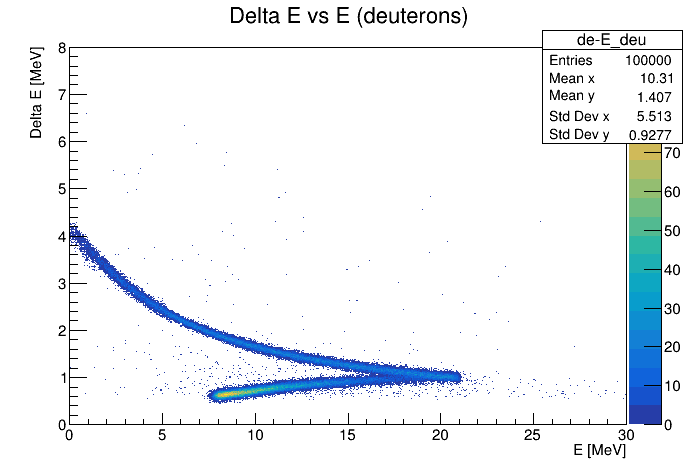

In [13]:
# Test simulation with energy distribution -- Deuteron
baseSimSetup_test3 = baseSimSetup.copy()
baseSimSetup_test3["BEAM"]         = "ion::1;2"
baseSimSetup_test3["ENERGY"]       = 20.0       #Reference energy[MeV]
baseSimSetup_test3["ENERGY_FLAT"]  = [1.0,40.0] #Energy distribution[MeV]

baseSimSetup_test3["MINIROOT"]     = False #I want TTrees

baseSimSetup_test3["OUTNAME"]      = "test3"

(twiss_test3, numPart_test3, objects_test3, datafile_test3) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test3, getRaw=True, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_2_edep","magnet_3_edep","init_E","metadata"])

th = datafile_test3.Get("magnetEdeps")
#th.Print()
#print(dir(th))

correlation_deu = ROOT.TH2D("de-E_deu", "Delta E vs E (deuterons)", nbins_small, 0, 30, nbins_small, 0, 8)

for i in range(th.GetEntries()):
    th.GetEntry(i)
    correlation_deu.Fill(th.magnet_2, th.magnet_1)
    correlation_all.Fill(th.magnet_2, th.magnet_1)

correlation_deu.SetXTitle("E [MeV]")    
correlation_deu.SetYTitle("Delta E [MeV]")

c1 = ROOT.TCanvas()
correlation_deu.Draw("colz")
c1.Draw()

Did not find any pre-computed data at '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test6.root', computing now.
Running command line: './MiniScatter --thick 0.0 --dist 5.0 --worldsize 20.0 --phys QGSP_BERT_EMV --numEvents 100000 --energy 20.0 --energyDistFlat 1.0:40.0 --beam ion::1;3 --zoffset -10 --outname test6 --outfolder /mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE --magnet 0.0:TARGET:0.13:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.8600000000000001:TARGET:1.55:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.07500000000000001:TARGET:0.01:0.0:material=G4_Al:width=15.0:height=15.0'
RunFolder = '/mn/kvant/u5/kyrrens/code/MiniScatter/build'
logName   = '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test6.txt'
|
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500


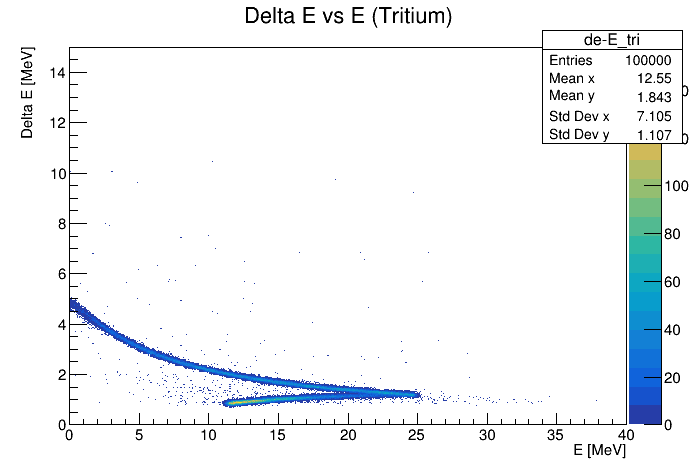

In [14]:
# Test simulation with energy distribution -- tritium
baseSimSetup_test6 = baseSimSetup.copy()
baseSimSetup_test6["BEAM"]         = "ion::1;3"
baseSimSetup_test6["ENERGY"]       = 20.0       #Reference energy[MeV]
baseSimSetup_test6["ENERGY_FLAT"]  = [1.0,40.0] #Energy distribution[MeV]

baseSimSetup_test6["MINIROOT"]     = False #I want TTrees

baseSimSetup_test6["OUTNAME"]      = "test6"

(twiss_test6, numPart_test6, objects_test6, datafile_test6) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test6, getRaw=True, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_2_edep","magnet_3_edep","init_E","metadata"])

th = datafile_test6.Get("magnetEdeps")
#th.Print()
#print(dir(th))

correlation_tri = ROOT.TH2D("de-E_tri", "Delta E vs E (Tritium)", nbins_small, 0, 40, nbins_small, 0, 15)

for i in range(th.GetEntries()):
    th.GetEntry(i)
    correlation_tri.Fill(th.magnet_2, th.magnet_1)
    correlation_all.Fill(th.magnet_2, th.magnet_1)

correlation_tri.SetXTitle("E [MeV]")    
correlation_tri.SetYTitle("Delta E [MeV]")

c1 = ROOT.TCanvas()
correlation_tri.Draw("colz")
c1.Draw()

Did not find any pre-computed data at '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test4.root', computing now.
Running command line: './MiniScatter --thick 0.0 --dist 5.0 --worldsize 20.0 --phys QGSP_BERT_EMV --numEvents 100000 --energy 20.0 --energyDistFlat 1.0:40.0 --beam ion::2;4 --zoffset -10 --outname test4 --outfolder /mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE --magnet 0.0:TARGET:0.13:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.8600000000000001:TARGET:1.55:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.07500000000000001:TARGET:0.01:0.0:material=G4_Al:width=15.0:height=15.0'
RunFolder = '/mn/kvant/u5/kyrrens/code/MiniScatter/build'
logName   = '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test4.txt'
|
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500


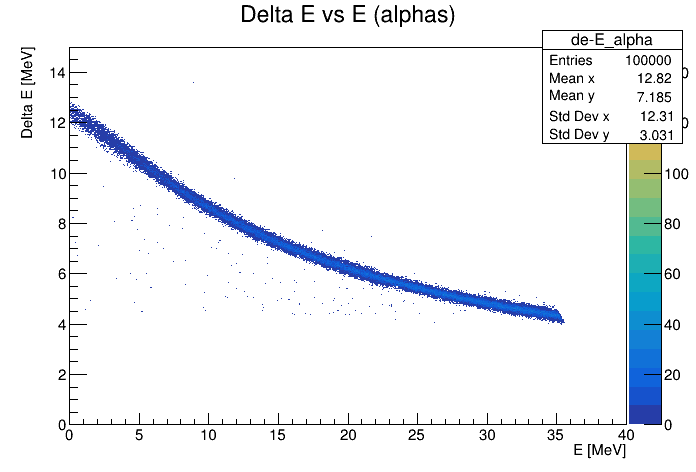

In [15]:
# Test simulation with energy distribution -- alpha
baseSimSetup_test4 = baseSimSetup.copy()
baseSimSetup_test4["BEAM"]         = "ion::2;4"
baseSimSetup_test4["ENERGY"]       = 20.0       #Reference energy[MeV]
baseSimSetup_test4["ENERGY_FLAT"]  = [1.0,40.0] #Energy distribution[MeV]

baseSimSetup_test4["MINIROOT"]     = False #I want TTrees

baseSimSetup_test4["OUTNAME"]      = "test4"

(twiss_test4, numPart_test4, objects_test4, datafile_test4) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test4, getRaw=True, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_2_edep","magnet_3_edep","init_E","metadata"])

th = datafile_test4.Get("magnetEdeps")
#th.Print()
#print(dir(th))

correlation_alpha = ROOT.TH2D("de-E_alpha", "Delta E vs E (alphas)", nbins_small, 0, 40, nbins_small, 0, 15)

for i in range(th.GetEntries()):
    th.GetEntry(i)
    correlation_alpha.Fill(th.magnet_2, th.magnet_1)
    correlation_all.Fill(th.magnet_2, th.magnet_1)

correlation_alpha.SetXTitle("E [MeV]")    
correlation_alpha.SetYTitle("Delta E [MeV]")

c1 = ROOT.TCanvas()
correlation_alpha.Draw("colz")
c1.Draw()

Did not find any pre-computed data at '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test5.root', computing now.
Running command line: './MiniScatter --thick 0.0 --dist 5.0 --worldsize 20.0 --phys QGSP_BERT_EMV --numEvents 100000 --energy 20.0 --energyDistFlat 1.0:40.0 --beam ion::2;3 --zoffset -10 --outname test5 --outfolder /mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE --magnet 0.0:TARGET:0.13:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.8600000000000001:TARGET:1.55:0.0:material=G4_Si:width=15.0:height=15.0 --magnet 0.07500000000000001:TARGET:0.01:0.0:material=G4_Al:width=15.0:height=15.0'
RunFolder = '/mn/kvant/u5/kyrrens/code/MiniScatter/build'
logName   = '/mn/kvant/u5/kyrrens/code/MiniScatter/examples/DeltaEE/test5.txt'
|
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500


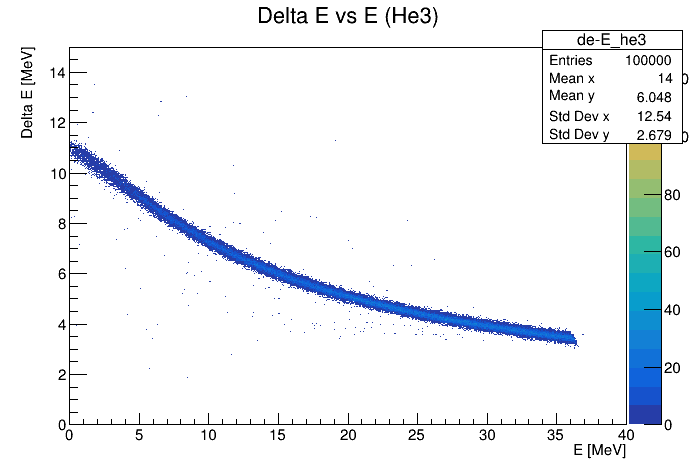

In [18]:
# Test simulation with energy distribution -- He3
baseSimSetup_test5 = baseSimSetup.copy()
baseSimSetup_test5["BEAM"]         = "ion::2;3"
baseSimSetup_test5["ENERGY"]       = 20.0       #Reference energy[MeV]
baseSimSetup_test5["ENERGY_FLAT"]  = [1.0,40.0] #Energy distribution[MeV]

baseSimSetup_test5["MINIROOT"]     = False #I want TTrees

baseSimSetup_test5["OUTNAME"]      = "test5"

(twiss_test5, numPart_test5, objects_test5, datafile_test5) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test5, getRaw=True, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_2_edep","magnet_3_edep","init_E","metadata"])

th = datafile_test5.Get("magnetEdeps")
#th.Print()
#print(dir(th))

correlation_he3 = ROOT.TH2D("de-E_he3", "Delta E vs E (He3)", nbins_small, 0, 40, nbins_small, 0, 15)

for i in range(th.GetEntries()):
    th.GetEntry(i)
    correlation_he3.Fill(th.magnet_2, th.magnet_1)
    correlation_all.Fill(th.magnet_2, th.magnet_1)

correlation_he3.SetXTitle("E [MeV]")    
correlation_he3.SetYTitle("Delta E [MeV]")

c1 = ROOT.TCanvas()
correlation_he3.Draw("colz")
c1.Draw()



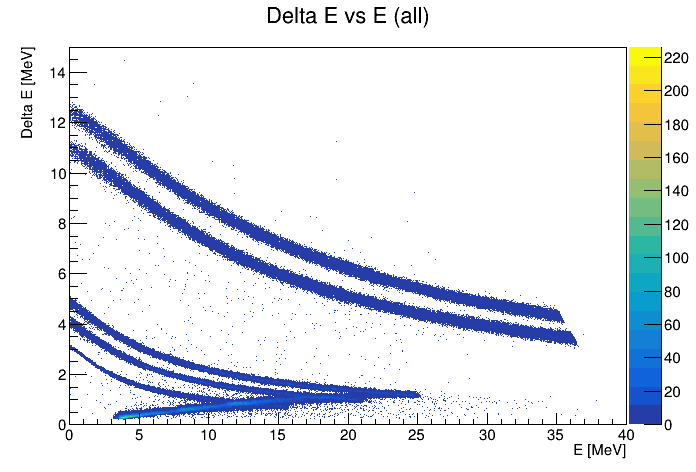

In [19]:
#Plot ALL of them on top of each other

c1 = ROOT.TCanvas()
correlation_all.SetStats(False)
correlation_all.Draw("colz")

correlation_all.SetXTitle("E [MeV]")    
correlation_all.SetYTitle("Delta E [MeV]")

c1.Draw()